In [1]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


plt.style.use("ggplot")

df = pd.read_csv("processed/13.csv")
df.head()

,review_time,card_id,rating,review_state,is_learn_start,sequence_group,last_learn_start,mask,delta_t,i,delta_t_f,t_bin,t_history,r_history,t_f_history,y
0,1623120877709,1377004882000,3,0,True,1,1,True,0,1,0.00s,1.0,NaN,NaN,NaN,1
1,1623120880749,1377004882001,3,0,False,1,0,True,0,1,0.00s,1.0,NaN,NaN,NaN,1
2,1623120883191,1377004882002,3,0,False,1,0,True,0,1,0.00s,1.0,NaN,NaN,NaN,1
3,1623120884832,1377004882003,3,0,False,1,0,True,0,1,0.00s,1.0,NaN,NaN,NaN,1
4,1623120886349,1377004882004,3,0,False,1,0,True,0,1,0.00s,1.0,NaN,NaN,NaN,1


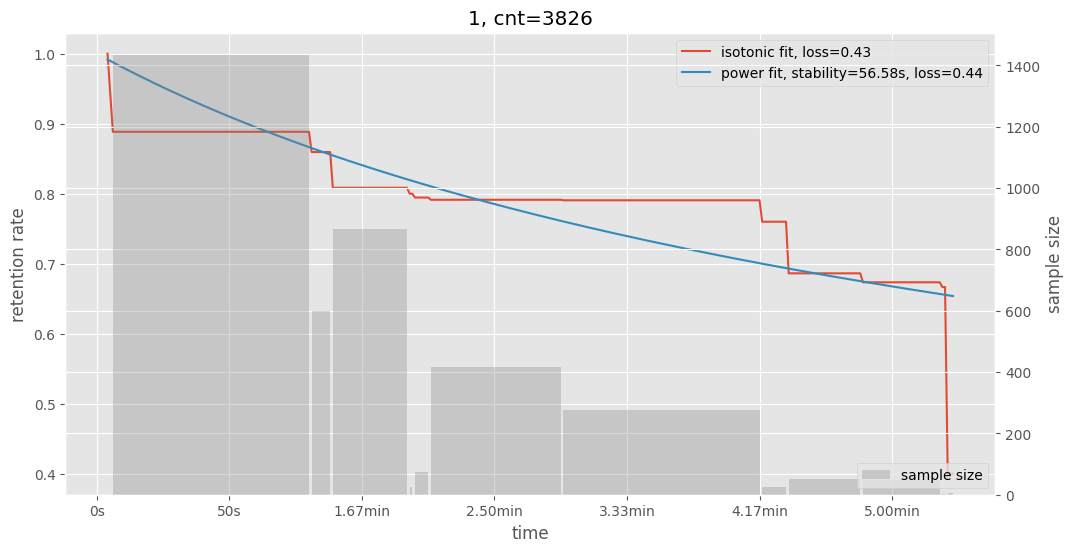

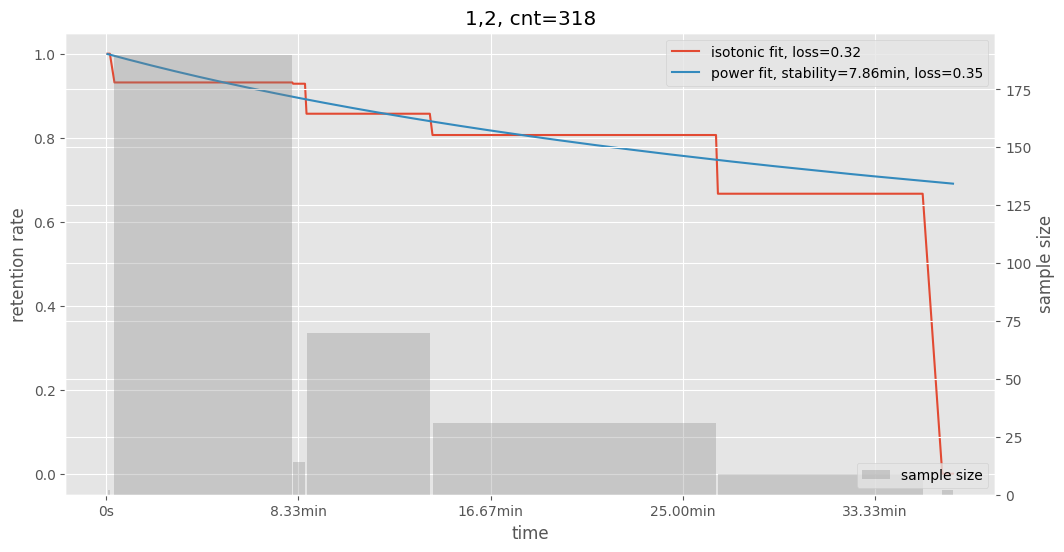

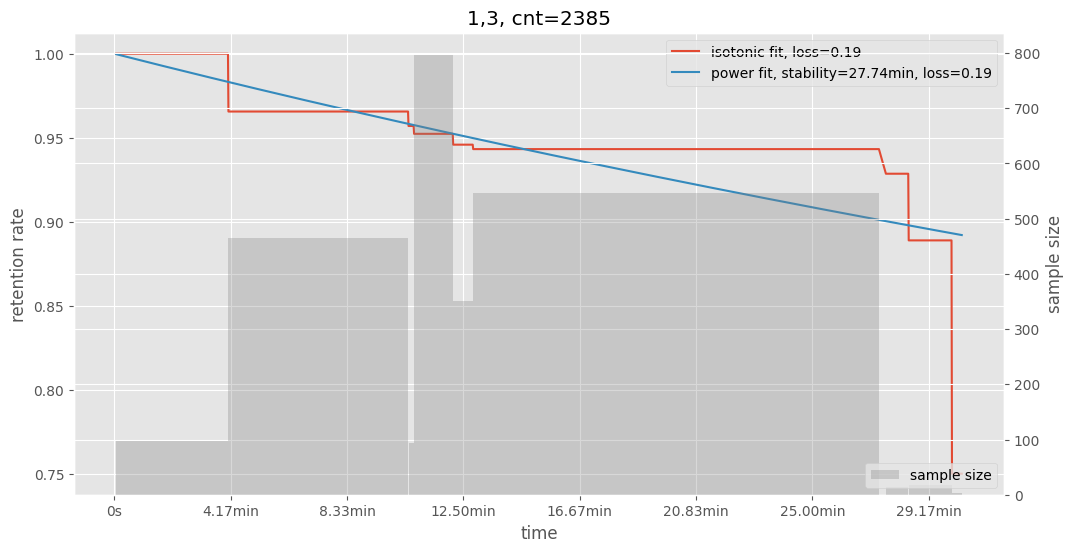

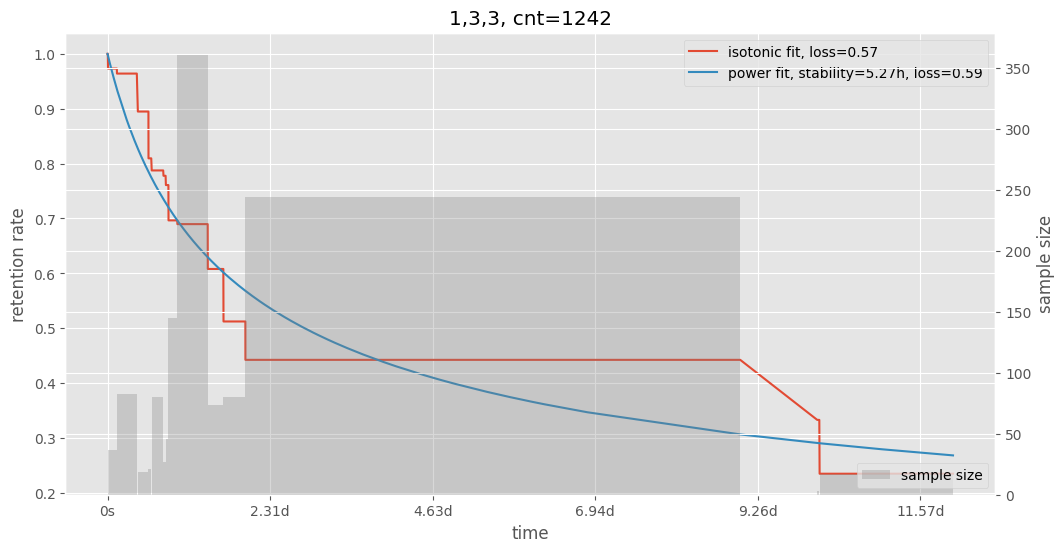

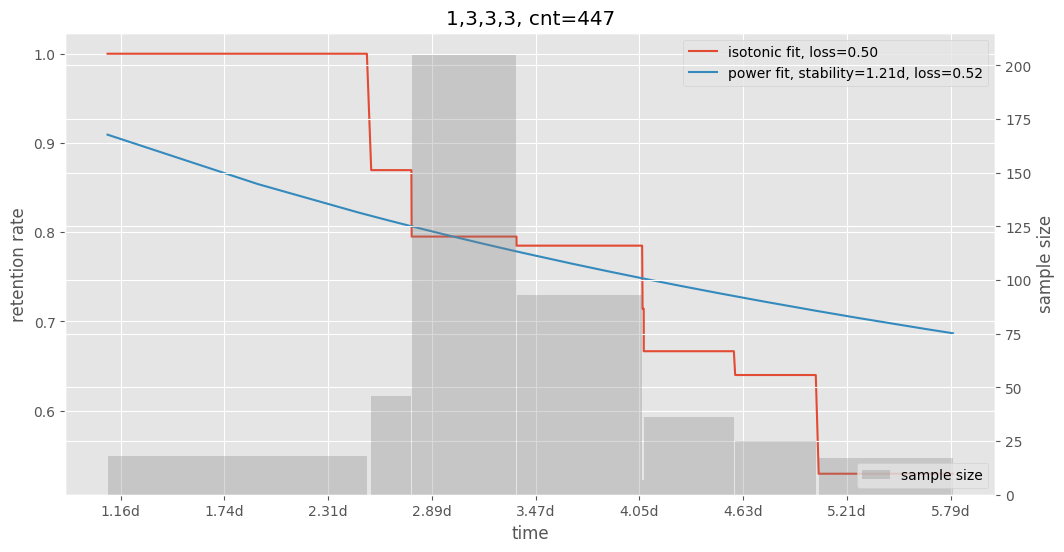

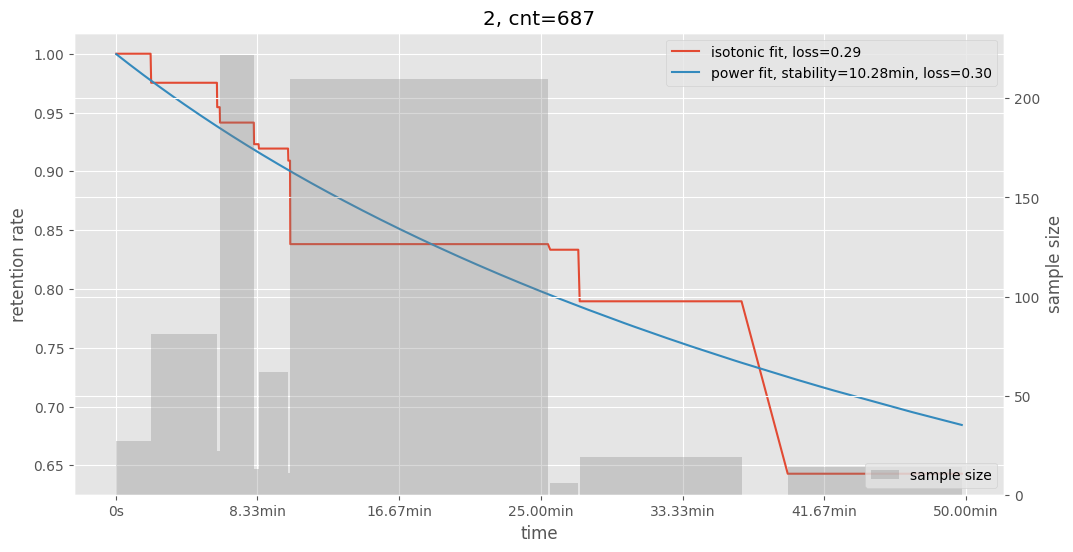

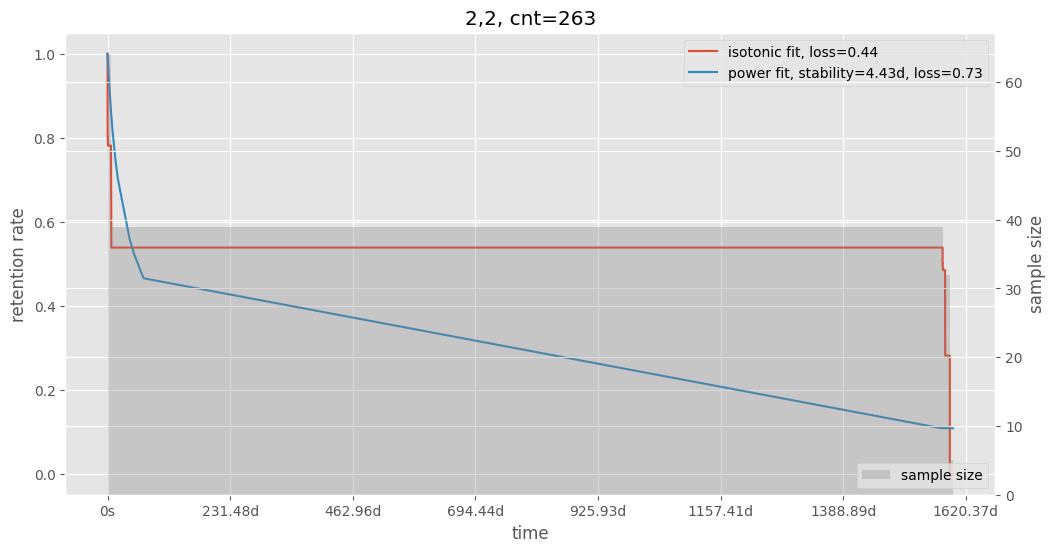

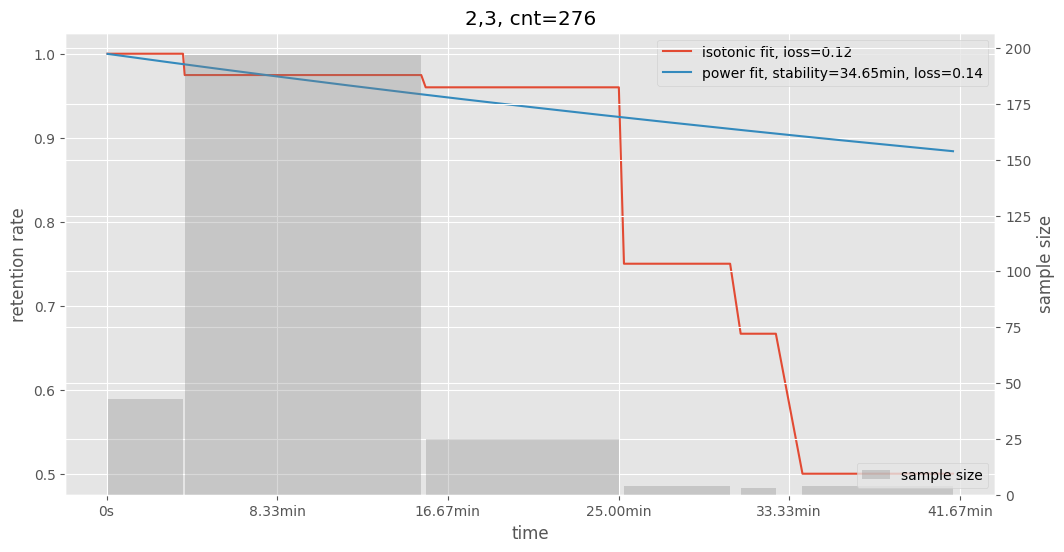

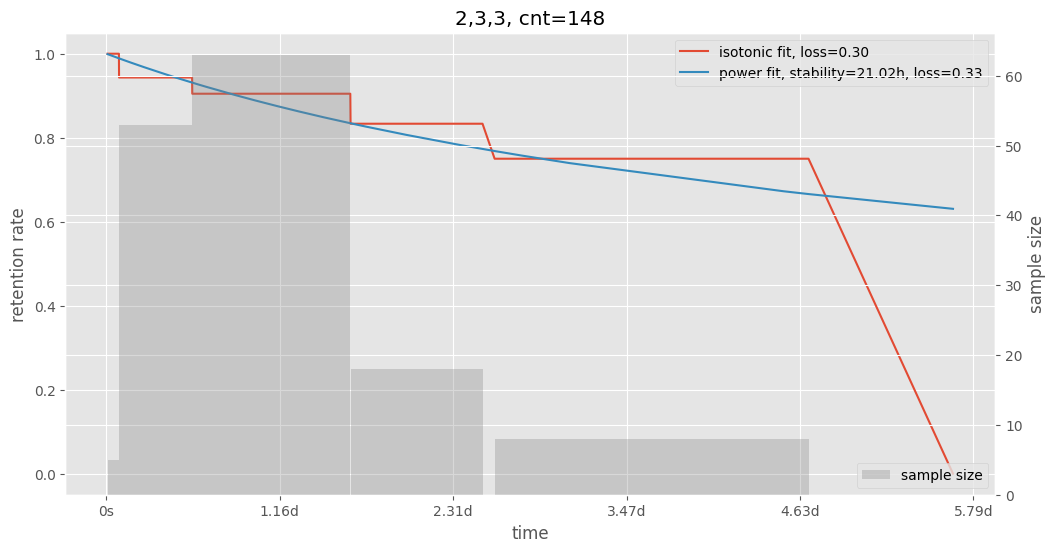

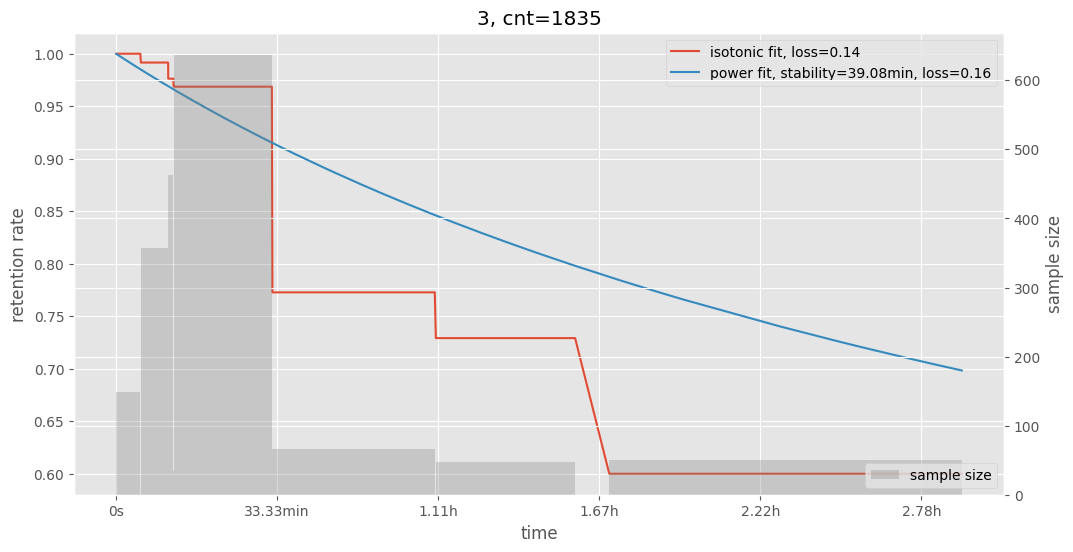

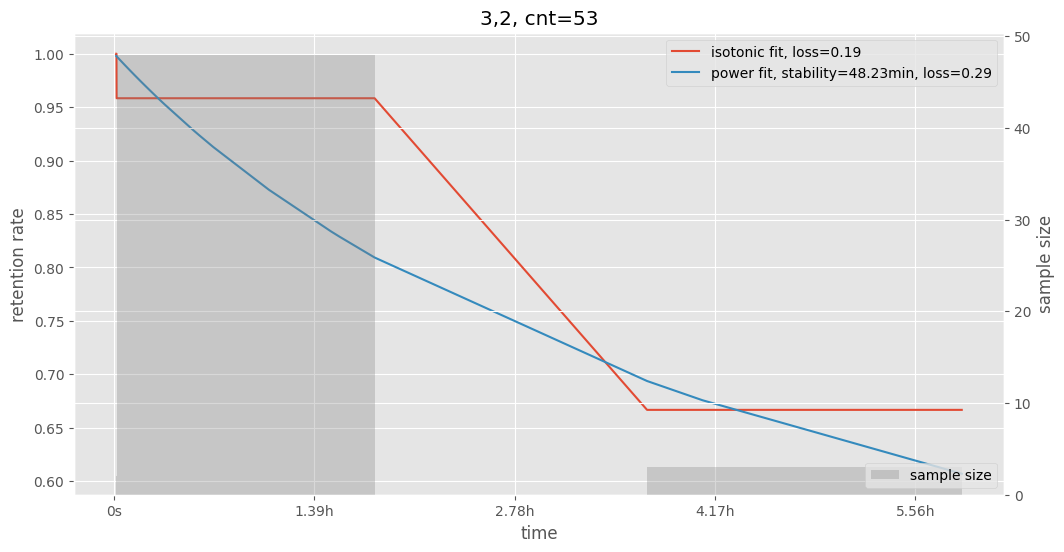

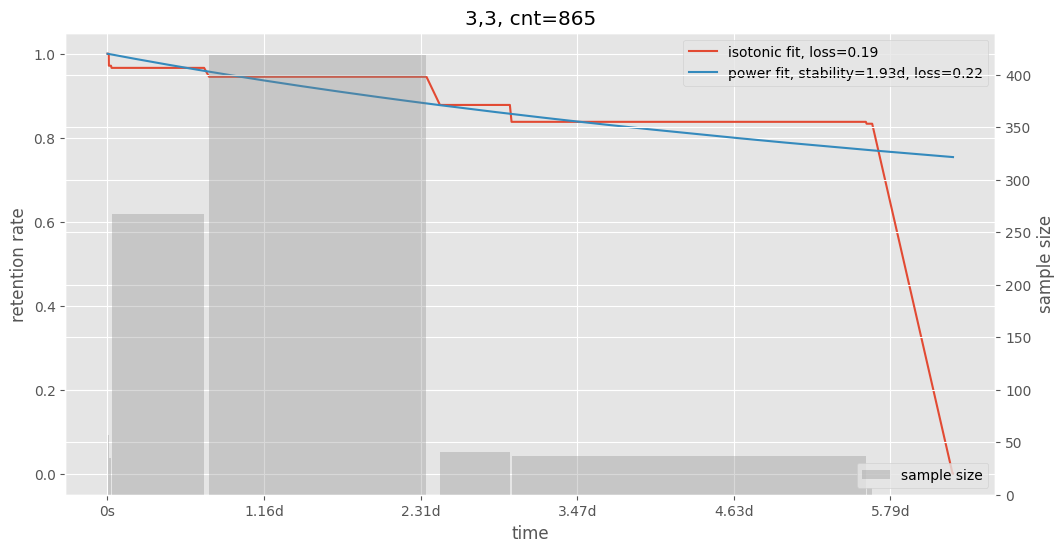

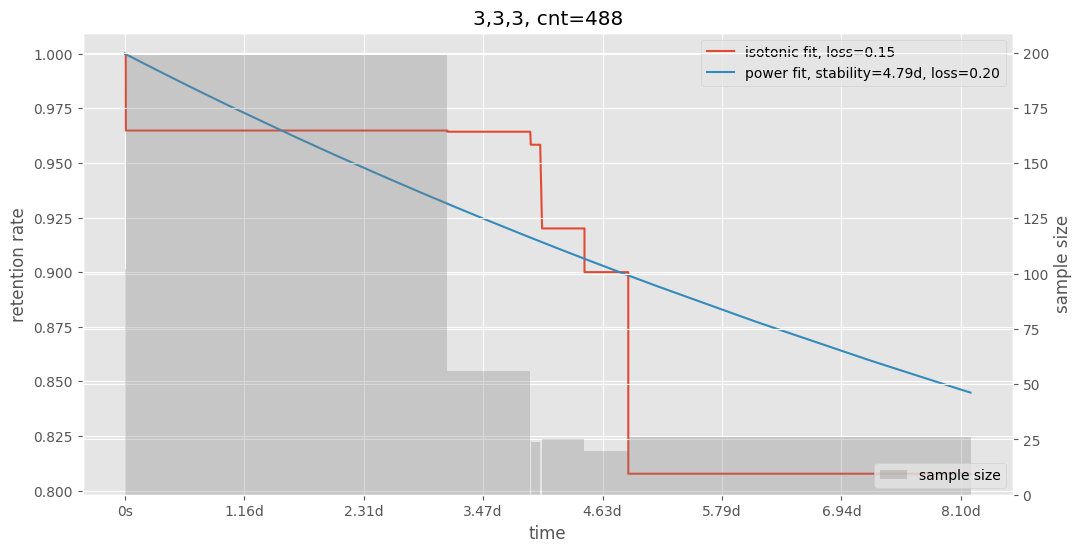

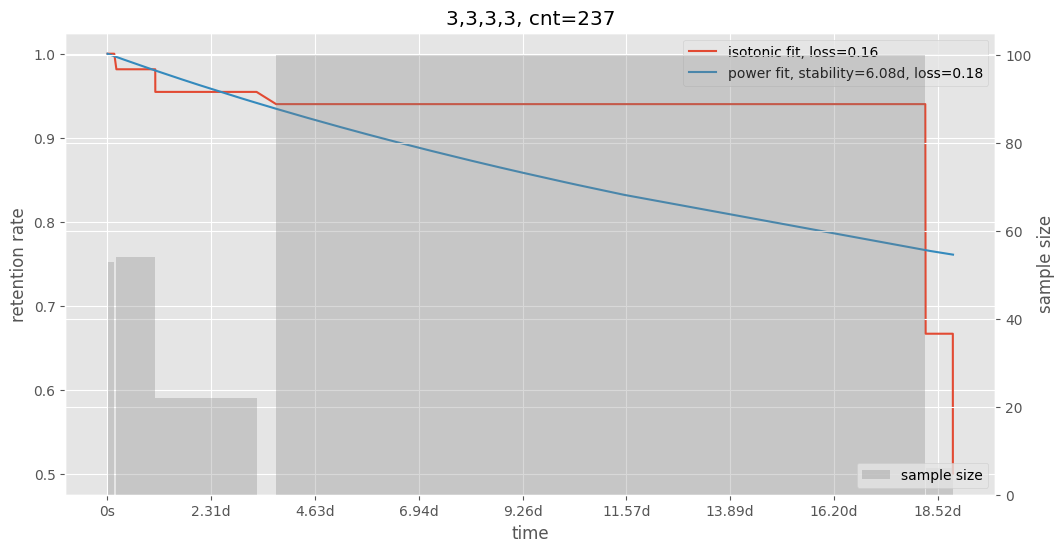

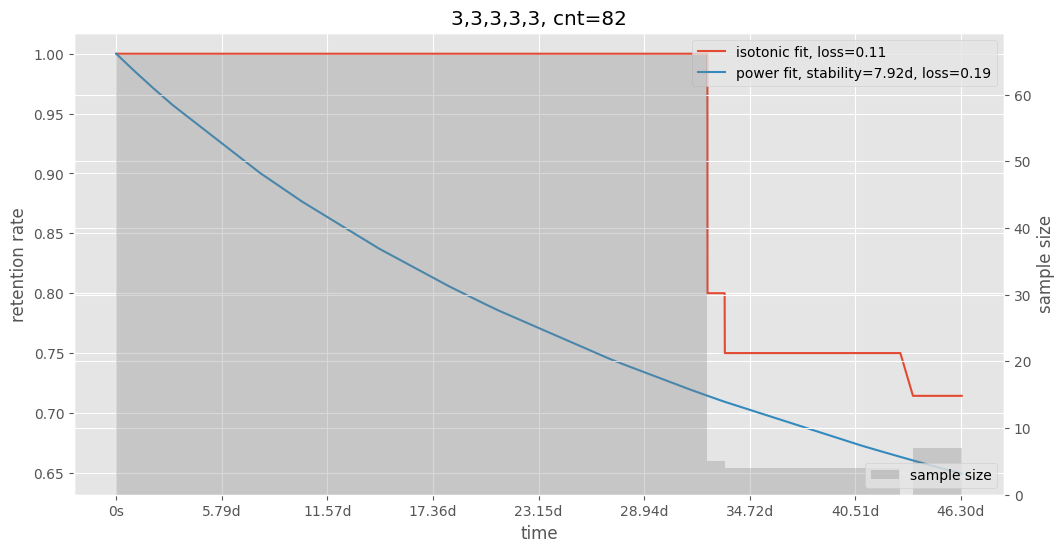

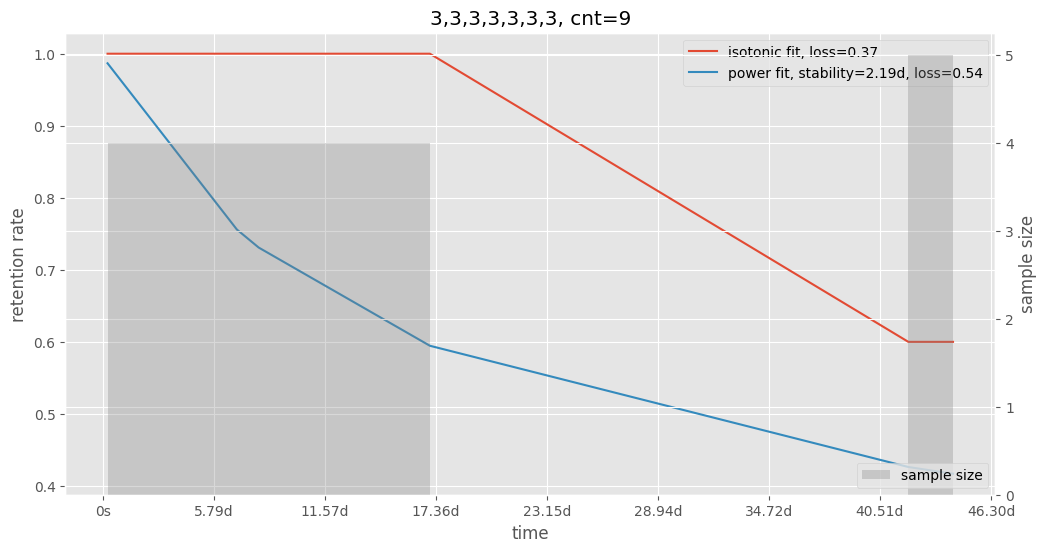

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


for r_history in (
    "1",
    "1,2",
    "1,3",
    "1,3,3",
    "1,3,3,3",
    "2",
    "2,2",
    "2,3",
    "2,3,3",
    "3",
    "3,2",
    "3,3",
    "3,3,3",
    "3,3,3,3",
    "3,3,3,3,3",
    "3,3,3,3,3,3",
    "3,3,3,3,3,3,3",
    "3,3,3,3,3,3,3,3",
):
    data = df[df["r_history"] == r_history][["delta_t", "y"]]
    Q1 = data["delta_t"].quantile(0.25)
    Q3 = data["delta_t"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[
        (data["delta_t"] >= lower_bound) & (data["delta_t"] <= upper_bound)
    ]
    x, y = filtered_data.sort_values(by="delta_t").values.T

    if all(y == 1):
        continue

    ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
    ir.fit(x, y)

    y_ir = ir.predict(x)
    loss_ir = log_loss(y, y_ir)

    s_seconds = fit_stability(x, y_ir, np.ones_like(x))
    s = (
        f"{s_seconds:.2f}s"
        if s_seconds < 60
        else (
            f"{s_seconds/60:.2f}min"
            if s_seconds < 3600
            else (
                f"{s_seconds/3600:.2f}h"
                if s_seconds < 86400
                else f"{s_seconds/86400:.2f}d"
            )
        )
    )
    y_pred = power_forgetting_curve(x, s_seconds)
    loss = log_loss(y, y_pred)
    cnt = len(x)

    # print(y_pred)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # ax1.plot(x, y, 'o', label='data')
    ax1.plot(x, y_ir, "-", label=f"isotonic fit, loss={loss_ir:.2f}")
    ax1.plot(x, y_pred, "-", label=f"power fit, stability={s}, loss={loss:.2f}")

    unique_y_ir = np.unique(y_ir)
    segment_counts = []
    segment_x = []
    segment_widths = []
    for i in range(len(unique_y_ir)):
        mask = y_ir == unique_y_ir[i]
        segment_counts.append(np.sum(mask))
        segment_x.append(np.min(x[mask]))
        segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

    ax2 = ax1.twinx()
    ax2.bar(
        segment_x,
        segment_counts,
        alpha=0.3,
        width=segment_widths,
        color="gray",
        label="sample size",
        align="edge",
    )
    ax1.set_title(f"{r_history}, cnt={cnt}")
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")

    # 设置x轴刻度
    def format_time(x, pos):
        if x < 60:
            return f"{x:.0f}s"
        elif x < 3600:
            return f"{x/60:.2f}min"
        elif x < 86400:
            return f"{x/3600:.2f}h"
        else:
            return f"{x/86400:.2f}d"

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))
    ax1.set_xlabel("time")
    ax1.set_ylabel("retention rate")
    ax2.set_ylabel("sample size")

    plt.show()